SADFasf asf asfasf as ASf a

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


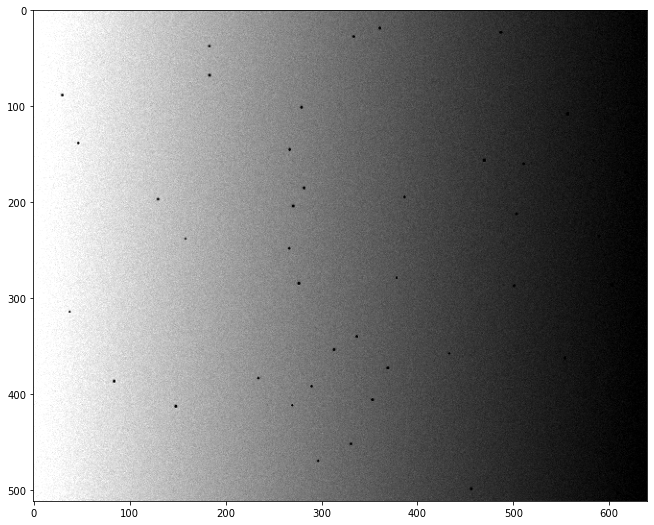

In [21]:
%load_ext autoreload
%autoreload 2

from loader import *
from models import *
from utils import *
from plotting import *

im_size_width, im_size_height, radius = 640, 512, 0.3e-6
plankton = stationary_spherical_plankton(im_size_height, im_size_width, radius, label=1)

gradient_amp = 0.5
microscope = plankton_brightfield(im_size_height, im_size_width, gradient_amp)

no_of_planktons = 50
sample = create_sample(plankton, no_of_planktons)

noise_amp = 2
norm_min, norm_max= -0.2, 1.2
image = create_image(noise_amp, sample, microscope, norm_min, norm_max)

plot_image(image)

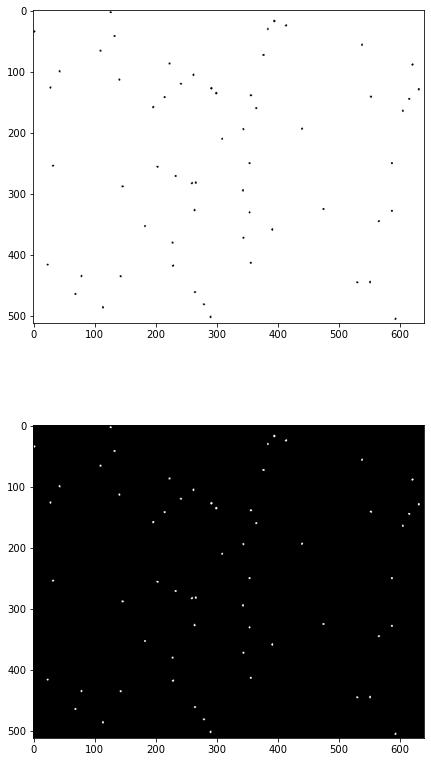

In [2]:
label = get_target_image(image.resolve())
label_function = get_target_image
plot_label(label_function, image)

In [4]:
batch_function = create_custom_batch_function(image, 
                                              outputs=[0], 
                                              function_img=[Normalize_image],
                                              function_diff=[Normalize_image])

In [5]:
from deeptrack.generators import ContinuousGenerator
generator = ContinuousGenerator(
    image,
    get_target_image,
    batch_function,
    batch_size=2,
    min_data_size=4,
    max_data_size=512
    )

In [6]:
no_of_inputs, number_of_outputs = 1, 2
model = generate_unet(im_size_height, im_size_width, no_of_inputs, number_of_outputs)
model = train_model(model, generator, patience=20, epochs=20, steps_per_epoch=2)

Generating 5 / 4 samples before starting training
Epoch 1/20
2/2 [==============================] - 0s 72ms/step - loss: 0.0012
Epoch 2/20
2/2 [==============================] - 0s 47ms/step - loss: 0.0010
Epoch 3/20
2/2 [==============================] - 0s 46ms/step - loss: 9.2003e-04
Epoch 4/20
2/2 [==============================] - 0s 40ms/step - loss: 0.0012
Epoch 5/20
2/2 [==============================] - 0s 41ms/step - loss: 0.0010
Epoch 6/20
2/2 [==============================] - 0s 41ms/step - loss: 9.9958e-04
Epoch 7/20
2/2 [==============================] - 0s 44ms/step - loss: 8.0791e-04
Epoch 8/20
2/2 [==============================] - 0s 41ms/step - loss: 0.0010
Epoch 9/20
2/2 [==============================] - 0s 39ms/step - loss: 9.2048e-04
Epoch 10/20
2/2 [==============================] - 0s 41ms/step - loss: 8.7100e-04
Epoch 11/20
2/2 [==============================] - 0s 39ms/step - loss: 9.7649e-04
Epoch 12/20
2/2 [==============================] - 0s 43ms/step - 

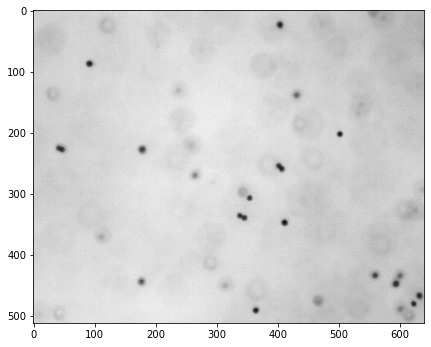

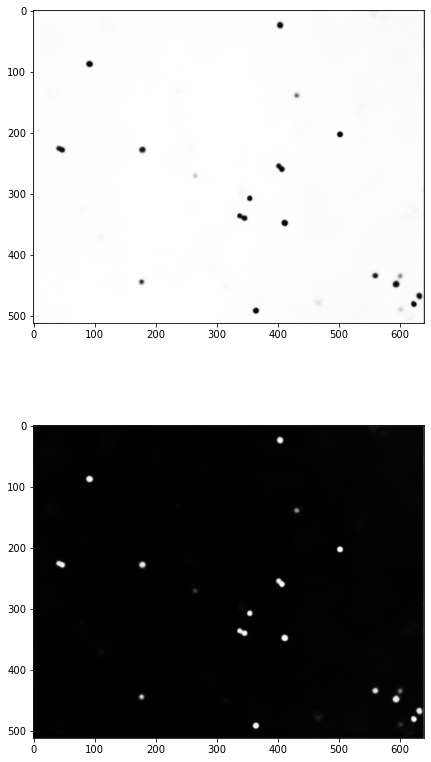

In [167]:
# outputs = ["img", "img", "img", "diff", "diff"]
# output_numbers = [0, 1, 2, [0,1], [1,2]]
folder_path = 'E:\Documents\Anaconda\Jupyterkod\Exjobb\Egen kod\Exjobb\From erik\\alexandrium2'
calculated_mean_image = get_mean_image(folder_path, im_size_width, im_size_height)
im_stack = get_image_stack(
    outputs=[0], 
    folder_path='E:\Documents\Anaconda\Jupyterkod\Exjobb\Egen kod\Exjobb\From erik\\alexandrium2', 
    frame_im0=16, 
    im_size_width=640, 
    im_size_height=512,
    function_img=[Normalize_image])

plot_im_stack(im_stack)
plot_prediction(model=model, im_stack=im_stack)

In [168]:
positions = extract_positions(
    no_of_frames=100, 
    outputs=[0], 
    folder_path='E:\Documents\Anaconda\Jupyterkod\Exjobb\Egen kod\Exjobb\From erik\\alexandrium2', 
    frame_im0=20, 
    im_size_width=640, 
    im_size_height=512,
    model=model, 
    layer=1, 
    value_threshold=0.7,
    function_img=[Normalize_image])


In [169]:
list_of_plankton = assign_positions_to_planktons(positions, max_dist=25, threshold=11, extrapolate=True)
list_of_plankton = Interpolate_gaps_in_plankton_positions(list_of_plankton=list_of_plankton)
list_of_plankton = Trim_list_from_stationary_planktons(list_of_plankton=list_of_plankton, min_distance=25)

plankton_track, plankton_dont_track = split_plankton(percentage_threshold=0, list_of_plankton=list_of_plankton)

In [170]:
plot_and_save_track(no_of_frames=len(list_of_plankton[list(list_of_plankton.keys())[0]].positions),
                    plankton_track=plankton_track,
                    plankton_dont_track=plankton_dont_track,
                    folder_path='E:\Documents\Anaconda\Jupyterkod\Exjobb\Egen kod\Exjobb\From erik\\alexandrium2',
                    frame_im0=16,
                    save_images=True,
                    show_plankton_track=True,
                    show_plankton_dont_track=True,
                    show_numbers_track=True,
                    show_numbers_dont_track=True,
                    show_numbers_specific_plankton=False,
                    show_specific_plankton=False,
                    specific_plankton=None,
                    color_plankton_track='b',
                    color_plankton_dont_track='r',
                    color_specific_plankton='w',
                    x_axis_label='microns',
                    y_axis_label='microns',
                    pixel_length_ratio=3,
                    save_path='E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Raw_output',
                    frame_name='track',
                    file_type='.jpg')


In [209]:
def get_mean_net_and_gross_distance(list_of_plankton=None, use_3D_dist=False):
    no_of_timesteps = list_of_plankton[list(list_of_plankton.keys())[0]].number_of_timesteps
    no_of_plankton = len(list_of_plankton)
    mean_net_distances = np.zeros([no_of_timesteps,1])
    mean_gross_distances = np.zeros([no_of_timesteps,1])

    positions = np.zeros((no_of_timesteps, 2*no_of_plankton))
    for index, key in enumerate(list_of_plankton):
        positions[:,2*index:2*(index+1)] = list_of_plankton[key].positions
        
    for i in range(no_of_plankton):
        counter = 0
        for j in range(no_of_timesteps):
            if np.isnan(positions[j,i*2]):
                counter+=1
            else:
                break
        positions[:,2*i:2*(i+1)] = np.roll(positions[:,2*i:2*(i+1)], -counter, axis=0)
        
        
    for i in range(no_of_timesteps-1):
        counter=0
        for j in range(no_of_plankton):
            if not np.isnan(positions[i+1,2*j]):
                counter+=1
                mean_net_distances[i] += np.linalg.norm(positions[i+1,2*j:2*(j+1)]-positions[0,2*j:2*(j+1)])
                
                for k in range(0,i+1):
                    if np.isnan(positions[k+1,2*j]):
                        break
                    mean_gross_distances[i] += np.linalg.norm(positions[k+1,2*j:2*(j+1)]-positions[k,2*j:2*(j+1)])
        if counter==0:
            
            print(counter)
            break
        
#         print(mean_net_distances[i])
#         print(mean_gross_distances[i])
        mean_net_distances[i] /= counter
        mean_gross_distances[i] /= counter
        
    if use_3D_dist:
        net_distances = net_distances * np.sqrt(3/2)
    return mean_net_distances, mean_gross_distances


# def get_total_distance(list_of_plankton=None, use_3D_dist=False):
#     no_of_timesteps = list_of_plankton[list(list_of_plankton.keys())[0]].number_of_timesteps
#     total_distances = np.zeros([len(list_of_plankton),1])
#     for index, key in enumerate(list_of_plankton):
#         temp_distance = 0
#         for i in range(no_of_timesteps-1):
#             if not np.isnan(list_of_plankton[key].positions[i][0]) and not np.isnan(list_of_plankton[key].positions[i+1][0]):
#                 temp_distance += np.linalg.norm((list_of_plankton[key].positions[i+1] - list_of_plankton[key].positions[i]).astype('float'))
                
#         total_distances[index] = temp_distance
#     if use_3D_dist:
#         total_distances = total_distances * np.sqrt(3/2)
#     return total_distances


mean_net_distance, mean_gross_distances = get_mean_net_and_gross_distance(list_of_plankton, use_3D_dist=False)
# total_distance = get_total_distance(list_of_plankton, use_3D_dist=False)

0


In [210]:
print(len(mean_gross_distances[mean_gross_distances!=0]))
len(mean_net_distance[mean_net_distance!=0])


64


64

0


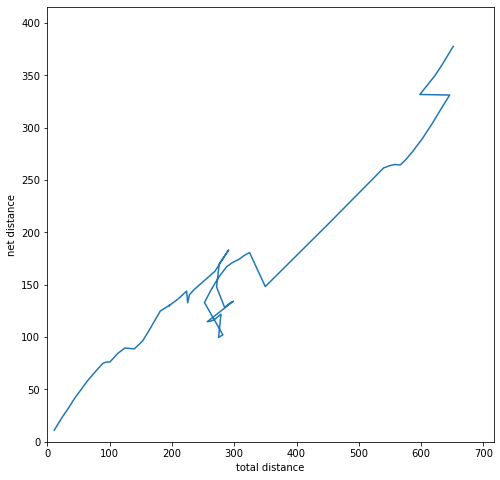

In [211]:
def plot_net_vs_gross_distance(list_of_plankton=None, **kwargs):
    net_distances, gross_distances = get_mean_net_and_gross_distance(list_of_plankton)
    plt.figure(figsize=(8,8))
    plt.axis([0, max(gross_distances[gross_distances!=0])*1.1, 0, max(net_distances[net_distances!=0])*1.1])
    plt.plot(gross_distances[gross_distances!=0], net_distances[net_distances!=0], **kwargs)
    plt.xlabel('total distance')
    plt.ylabel('net distance')
plot_net_vs_gross_distance(list_of_plankton=plankton_track)

In [41]:
Make_video(frame_im0=20,
           folder_path='E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Raw_output', 
           save_path='E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Test_video.avi', 
           fps=7, 
           no_of_frames=40)

In [66]:
save_positions(list_of_plankton, 
               save_path='E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\DeepTrack-2.0\\projects\\track plankton', 
               file_format='.csv', 
               pixel_length_ratio=1)

In [ ]:
# save_path_model = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\Test simulations\\Transfer rep 5 and 6\\results\\ver1\\models\\seq_len1_b10_few_plantkon.keras'
# model.save(save_path_model)


In [ ]:
# load_path_model = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\Test simulations\\Transfer rep 5 and 6\\results\\ver1\\models\\seq_len1_b7.keras'
# model = keras.models.load_model(load_path_model, custom_objects={'softmax_categorical':softmax_categorical})